In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from timeit import default_timer as timer

# Preprocessing

In [2]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df.sample(10)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
566797,566797,0.086396,0.003577,1027.100,0.171030,0.22426,0.99005,2176.600,508780.0,6.199700e+14,...,-18.5670,1.5398,87.60600,6.2257,38616.00,1.1517,-9.137600e+12,5108.30,0.11558,0
195591,195591,0.078998,0.451890,13355.000,0.399150,0.41981,-2.93130,2844.900,63924.0,2.471100e+12,...,-56.1640,1.8545,2.36830,-0.8103,8192.30,1.1683,-1.568400e+15,1242.80,1.42460,1
797590,797590,0.097777,0.492240,304.300,0.282270,0.35241,-1.27680,2286.000,491100.0,5.219300e+15,...,-1.7454,1.9205,-3.05030,2.2982,547.73,1.1684,6.104600e+16,463.22,0.12976,1
366590,366590,0.125770,0.506750,5906.500,0.019980,0.20086,0.76082,1834.100,222540.0,4.404600e+15,...,-3.7844,2.2652,-2.21270,5.2288,61557.00,1.1539,1.494100e+14,236.29,0.29064,0
740246,740246,NaN,0.372460,3218.600,0.136260,0.32402,2.30320,937.490,175340.0,5.256000e+12,...,-9.5488,1.8601,-1.40650,-1.6131,51966.00,1.2487,2.645300e+17,3601.10,0.20687,0
76022,76022,0.092412,NaN,91.955,0.188080,-0.00579,-0.31863,2402.600,40975.0,1.309800e+14,...,-42.1690,1.7710,167.95000,10.2400,50588.00,1.0849,1.937600e+16,4507.90,0.66551,1
168820,168820,0.089718,0.005624,5897.000,0.000231,0.26211,-1.16330,1583.700,141820.0,2.345600e+15,...,-32.7790,1.6024,155.48000,7.7298,807.82,1.1750,2.259200e+14,NaN,0.42530,1
197352,197352,0.117080,0.395630,730.750,0.522160,0.40322,2.12930,964.240,832260.0,3.781800e+14,...,NaN,1.4659,3.65700,-18.3940,45056.00,1.2081,4.245100e+13,180.44,0.12438,1
102558,102558,0.133920,0.325820,6093.800,0.366320,0.43962,6.59500,98.077,6820.4,4.301100e+15,...,-69.3360,1.9518,NaN,8.4623,3518.30,1.3450,1.225900e+14,753.91,0.45990,0
779489,779489,0.071984,-0.005232,7486.200,0.094290,0.36954,-0.76122,88.684,35121.0,NaN,...,-22.8880,1.7248,-0.14865,25.0830,4521.10,1.3401,7.789700e+16,717.41,0.43604,1


In [4]:
df = df.drop(columns='id')
df_test = df_test.drop(columns='id')

## Impute missing values

In [5]:
df.isnull().sum()

f1       15247
f2       15190
f3       15491
f4       15560
f5       15405
         ...  
f115     15559
f116     15589
f117     15407
f118     15212
claim        0
Length: 119, dtype: int64

In [6]:
df = df.fillna(df.median())
df_test = df_test.fillna(df.median())

In [7]:
df.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

## Check balance

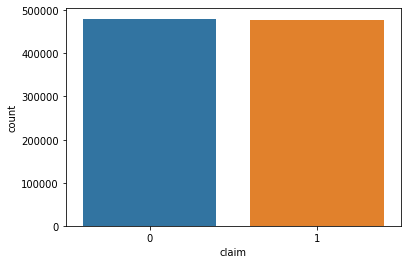

In [8]:
sns.countplot(data=df, x='claim');
# balanced

## Get X,y and split into train and val sets

In [16]:
frac = 0.001
X = df.drop(columns='claim').sample(frac=frac, random_state=42)
y = df['claim'].sample(frac=frac, random_state=42)

X_test = df_test

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((766, 118), (192, 118))

## Scaling

In [18]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

## Feature Selection

In [19]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

%timeit
estimator = RandomForestRegressor(n_estimators=100, n_jobs=-1) 
rfe = RFE(estimator, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_val_rfe = rfe.fit_transform(X_val, y_val)
X_test_rfe = rfe.fit_transform(X_test, y_test)

In [ ]:
rfe_features = X_train.columns[rfe.support_]
rfe_features

In [ ]:
X_train_ = pd.DataFrame(X_train, columns=rfe_features)
X_val_ = pd.DataFrame(X_val, columns=rfe_features)
X_test_ = pd.DataFrame(X_test, columns=rfe_features)

## ML Models

In [12]:
def fit_ML_model(modelName, model, acc=pd.DataFrame([], index=['Train Accuracy','Test Accuracy','Time (s)'])):

    from sklearn.metrics import accuracy_score
    
    start = timer()
    model.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_val = accuracy_score(y_val, model.predict(X_val))
    end = timer()

    acc[modelName] = [acc_train, acc_val, end-start]

    return model, acc

### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

gb, acc = fit_ML_model('LogReg', LogisticRegression())
acc

,LogReg
Train Accuracy,0.528817
Test Accuracy,0.530535
Time (s),2.627555


### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

start = timer()
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.2, max_depth=10, 
                    tree_method='exact', use_label_encoder=False, n_jobs=16)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='logloss', 
        early_stopping_rounds=5, verbose=1)

acc_train = accuracy_score(y_train, xgb.predict(X_train))
acc_val = accuracy_score(y_val, xgb.predict(X_val))
end = timer()

acc['XGBoost'] = [acc_train, acc_val, end-start]
acc

### Neural Network

In [14]:
import tensorflow as tf
from tensorflow import keras

nodes = 256
n_hidden = 5
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for i in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))
#     ann.add(keras.layers.Dense(nodes//(2**(i+1)), activation=activation))

ann.add(keras.layers.Dense(2, activation="softmax"))

ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               30464     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 294,146
Trainable params: 294,146
Non-trainable params: 0
__________________________________________________

In [15]:
epochs = 1000
batch_size = 10000

# lr =1e-2 # epcohs 0 --> 50 
lr =5e-3 # epochs 50 --> 100 

optimizer = tf.keras.optimizers.SGD(learning_rate=lr) 
ann.compile(loss='binary_crossentropy', optimizer=optimizer)

start = timer()
history = ann.fit(X_train, pd.get_dummies(y_train), validation_data=(X_val, pd.get_dummies(y_val)), 
                    epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size)
end = timer()

Epoch 1/1000
77/77 [==============================] - 9s 112ms/step - loss: 0.6959 - val_loss: 0.6946
Epoch 2/1000
77/77 [==============================] - 7s 92ms/step - loss: 0.6945 - val_loss: 0.6941
Epoch 3/1000
77/77 [==============================] - 7s 91ms/step - loss: 0.6942 - val_loss: 0.6940
Epoch 4/1000
77/77 [==============================] - 7s 92ms/step - loss: 0.6941 - val_loss: 0.6940
Epoch 5/1000
77/77 [==============================] - 7s 91ms/step - loss: 0.6940 - val_loss: 0.6939
Epoch 6/1000
77/77 [==============================] - 7s 90ms/step - loss: 0.6940 - val_loss: 0.6939
Epoch 7/1000
77/77 [==============================] - 7s 92ms/step - loss: 0.6940 - val_loss: 0.6939
Epoch 8/1000
77/77 [==============================] - 7s 91ms/step - loss: 0.6940 - val_loss: 0.6938
Epoch 9/1000
77/77 [==============================] - 7s 90ms/step - loss: 0.6939 - val_loss: 0.6938
Epoch 10/1000
77/77 [==============================] - 7s 91ms/step - loss: 0.6940 - val_l

KeyboardInterrupt: 

In [ ]:
acc_train = accuracy_score(y_train, ann.predict(X_train, batch_size=batch_size).argmax(axis=1))
acc_val = accuracy_score(y_val, ann.predict(X_val, batch_size=batch_size).argmax(axis=1))
end = timer()

acc['ann'] = [acc_train, acc_val, end-start]
acc